# [**Régression de Poisson et perte non normale**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/1_1_linear_model/plot_poisson_regression_non_normal_loss.ipynb)<br/>([_Poisson regression and non-normal loss_](https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html))

Cet exemple illustre l'utilisation de la régression de Poisson log-linéaire sur l'[ensemble de données des réclamations de responsabilité civile automobile en France](https://www.openml.org/search?type=data&sort=runs&id=41214&status=active) provenant de [1] et la compare avec un modèle linéaire ajusté avec l'erreur quadratique moyenne habituelle et un modèle GBRT (Gradient Boosting Regression Trees) non linéaire ajusté avec la perte de Poisson (et une liaison logarithmique).

Quelques définitions :
- Une **police d'assurance** est un contrat entre une compagnie d'assurance et un individu : le **titulaire de la police**, c'est-à-dire le conducteur du véhicule dans ce cas.
- Une **réclamation** est la demande formulée par un titulaire de police à l'assureur pour être indemnisé d'une perte couverte par l'assurance.
- L'**exposition** est la durée de la couverture d'assurance d'une police donnée, en années.
- La **fréquence des réclamations** est le nombre de réclamations divisé par l'exposition, généralement mesurée en nombre de réclamations par an.

Dans cet ensemble de données, chaque échantillon correspond à une police d'assurance. Les caractéristiques disponibles comprennent l'âge du conducteur, l'âge du véhicule, la puissance du véhicule, etc.

Notre objectif est de prédire la fréquence attendue des réclamations suite à des accidents de voiture pour un nouveau titulaire de police en utilisant les données historiques sur une population de titulaires de police.

🔬 [1] A. Noll, R. Salzmann et M.V. Wuthrich, [**“Étude de cas : Réclamations de responsabilité civile automobile en France”**](http://dx.doi.org/10.2139/ssrn.3164764) (8 novembre 2018).

In [1]:
# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# L'ensemble de données des réclamations de responsabilité civile automobile en France

Chargeons l'ensemble de données des réclamations automobiles depuis OpenML : https://www.openml.org/d/41214

In [2]:
from sklearn.datasets import fetch_openml

df = fetch_openml(data_id=41214, as_frame=True, parser="pandas").frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


Le nombre de réclamations (`ClaimNb`) est un entier positif qui peut être modélisé comme une distribution de Poisson. On suppose alors que c'est le nombre d'événements discrets se produisant à un taux constant dans un intervalle de temps donné (`Exposure`, en unités d'années).

Ici, nous voulons modéliser la fréquence `y = ClaimNb / Exposure` conditionnellement à `X` via une distribution de Poisson (mise à l'échelle), et utiliser `Exposure` comme `sample_weight`.

Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


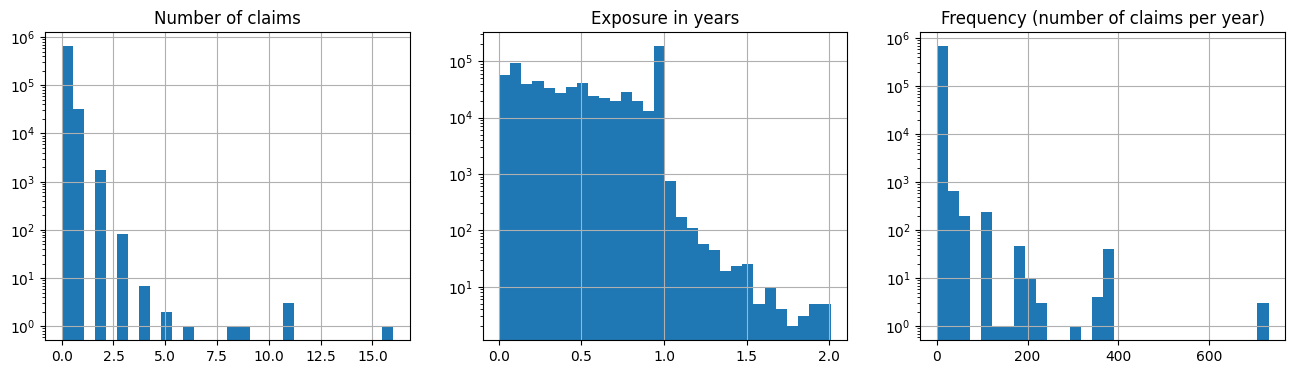

In [3]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

Les colonnes restantes peuvent être utilisées pour prédire la fréquence des événements de réclamation. Ces colonnes sont très hétérogènes avec un mélange de variables catégorielles et numériques avec différentes échelles, éventuellement très inégalement réparties.

Afin d'ajuster des modèles linéaires avec ces prédicteurs, il est donc nécessaire de réaliser des transformations de caractéristiques standard comme suit :

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

# Une ligne de base de prédiction constante

Il convient de noter que plus de 93 % des titulaires de police n'ont aucune réclamation. Si nous devions convertir ce problème en une tâche de classification binaire, il serait nettement déséquilibré, et même un modèle simpliste qui ne prédit que la moyenne pourrait atteindre une précision de 93 %.

Pour évaluer la pertinence des métriques utilisées, nous considérerons comme ligne de base un estimateur "dummy" qui prédit constamment la fréquence moyenne de l'échantillon d'entraînement.

In [5]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

Calculons la performance de cette ligne de base de prédiction constante avec 3 métriques de régression différentes :

In [6]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_poisson_deviance,
    mean_squared_error,
)


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


# Modèles linéaires (généralisés)

Nous commençons par modéliser la variable cible avec le modèle de régression linéaire des moindres carrés ($\ell_2$ pénalisé), plus communément connu sous le nom de régression Ridge. Nous utilisons une pénalisation faible `alpha`, car nous nous attendons à ce qu'un tel modèle linéaire sous-ajuste sur un ensemble de données aussi vaste.

In [7]:
from sklearn.linear_model import Ridge

ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

La déviance de Poisson ne peut pas être calculée sur des valeurs non positives prédites par le modèle. Pour les modèles qui renvoient quelques prédictions non positives (par exemple [**`Ridge`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)), nous ignorons les échantillons correspondants, ce qui signifie que la déviance de Poisson obtenue est approximative. Une approche alternative pourrait consister à utiliser le méta-estimateur [**`TransformedTargetRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html) pour mapper `y_pred` vers un domaine strictement positif.

In [8]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.597


Ensuite, nous ajustons le régresseur de Poisson sur la variable cible. Nous fixons la force de régularisation `alpha` à environ 1e-6 sur le nombre d'échantillons (c'est-à-dire `1e-12`) afin de reproduire le régresseur Ridge dont le terme de pénalité $\ell_2$ est mis à l'échelle différemment avec le nombre d'échantillons.

Étant donné que le régresseur de Poisson modélise internement le logarithme de la valeur cible attendue au lieu de la valeur attendue directement (fonction de liaison logarithmique vs identité), la relation entre $X$ et $y$ n'est plus exactement linéaire. Par conséquent, le régresseur de Poisson est appelé un modèle linéaire généralisé (GLM) plutôt qu'un modèle linéaire classique comme c'est le cas pour la régression Ridge.

In [9]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, solver="newton-cholesky")),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


# Arbres de régression à gradient boosting pour la régression de Poisson

Enfin, nous considérerons un modèle non linéaire, à savoir les arbres de régression à gradient boosting. Les modèles basés sur les arbres n'exigent pas que les données catégorielles soient encodées en "one-hot" : à la place, nous pouvons encoder chaque étiquette de catégorie avec un entier arbitraire en utilisant [**`OrdinalEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Avec cet encodage, les arbres traiteront les caractéristiques catégorielles comme des caractéristiques ordonnées, ce qui pourrait ne pas toujours être un comportement souhaité. Cependant, cet effet est limité pour des arbres suffisamment profonds qui peuvent récupérer la nature catégorielle des caractéristiques. L'avantage principal de [**`OrdinalEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) par rapport à [**`OneHotEncoder`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) est qu'il accélère l'entraînement.

Le gradient boosting offre également la possibilité d'ajuster les arbres avec une perte de Poisson (avec une fonction de liaison logarithmique implicite) au lieu de la perte des moindres carrés par défaut. Ici, nous n'ajustons que des arbres avec la perte de Poisson pour conserver la concision de cet exemple.

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.559
MAE: 0.183
mean Poisson deviance: 0.575


Comme pour le modèle GLM de Poisson ci-dessus, le modèle d'arbres de gradient boosting minimise la déviance de Poisson. Cependant, en raison d'une plus grande puissance prédictive, il atteint des valeurs inférieures de la déviance de Poisson.

Évaluer les modèles avec un seul partage d'entraînement / test est sujet à des fluctuations aléatoires. Si les ressources informatiques le permettent, il convient de vérifier si les métriques de performance validées par validation croisée conduiraient à des conclusions similaires.

La différence qualitative entre ces modèles peut également être visualisée en comparant l'histogramme des valeurs cibles observées avec celui des valeurs prédites :

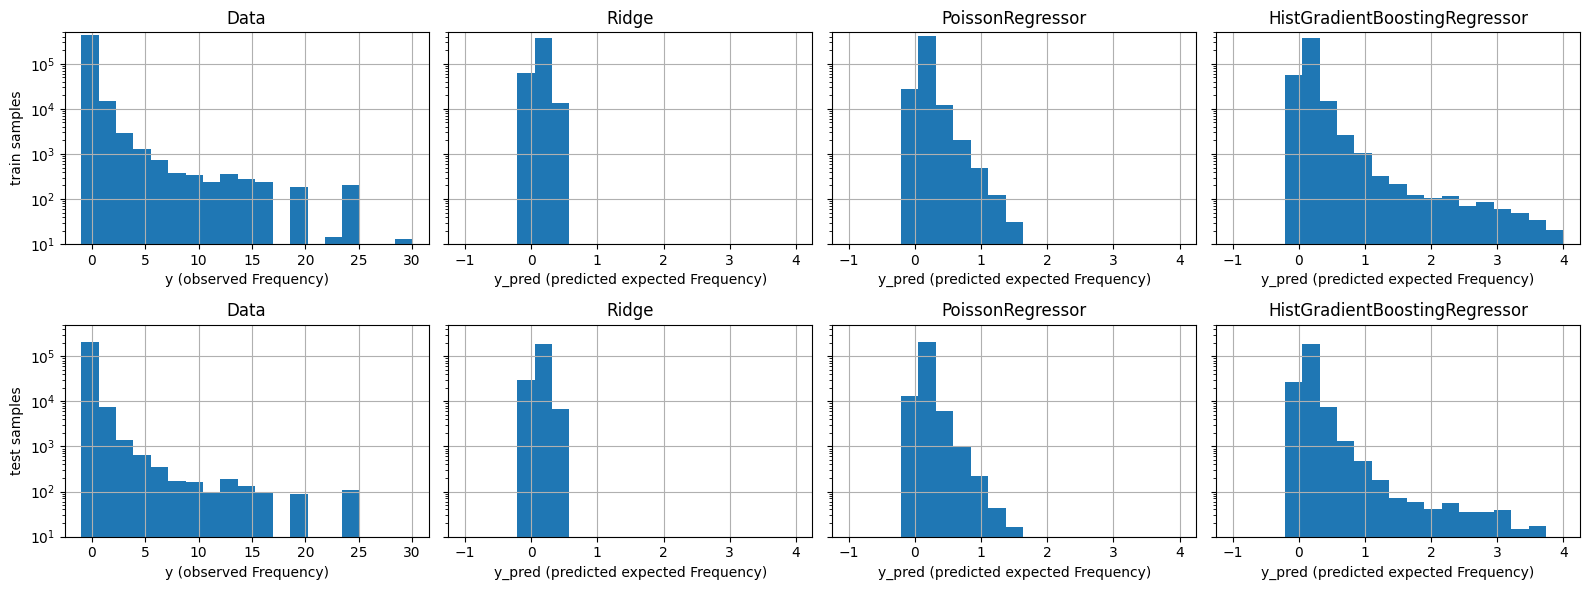

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(f"{label} samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

Les données expérimentales présentent une distribution à longue traîne pour `y`. Dans tous les modèles, nous prédisons la fréquence attendue d'une variable aléatoire, nous aurons donc nécessairement moins de valeurs extrêmes que pour les réalisations observées de cette variable aléatoire. Cela explique que le mode des histogrammes des prédictions du modèle ne correspond pas nécessairement à la plus petite valeur. De plus, la distribution normale utilisée dans `Ridge` a une variance constante, tandis que pour la distribution de Poisson utilisée dans `PoissonRegressor` et `HistGradientBoostingRegressor`, la variance est proportionnelle à la valeur attendue prédite.

Ainsi, parmi les estimateurs considérés, `PoissonRegressor` et `HistGradientBoostingRegressor` sont a priori mieux adaptés pour modéliser la distribution à longue traîne des données non négatives par rapport au modèle `Ridge`, qui fait une mauvaise hypothèse sur la distribution de la variable cible.

L'estimateur `HistGradientBoostingRegressor` est le plus flexible et peut prédire des valeurs attendues plus élevées.

Notez que nous aurions pu utiliser la perte des moindres carrés pour le modèle `HistGradientBoostingRegressor`. Cela aurait faussement supposé une variable de réponse distribuée normalement, comme le modèle `Ridge`, et pourrait également conduire à des prédictions légèrement négatives. Cependant, les arbres de gradient boosting performeraient toujours relativement bien et en particulier mieux que `PoissonRegressor`, grâce à la flexibilité des arbres combinée au grand nombre d'échantillons d'entraînement.

# Évaluation de l'étalonnage des prédictions

Pour garantir que les estimateurs produisent des prédictions raisonnables pour différents types de titulaires de police, nous pouvons regrouper les échantillons de test en fonction de `y_pred` retourné par chaque modèle. Ensuite, pour chaque groupe, nous comparons la moyenne prévue `y_pred`, avec la moyenne observée réelle :

Actual number of claims: 11935
Predicted number of claims by Ridge(alpha=1e-06): 11933.4
Predicted number of claims by PoissonRegressor(alpha=1e-12, solver='newton-cholesky'): 11932.0
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 12084.5
Predicted number of claims by DummyRegressor(): 11931.2


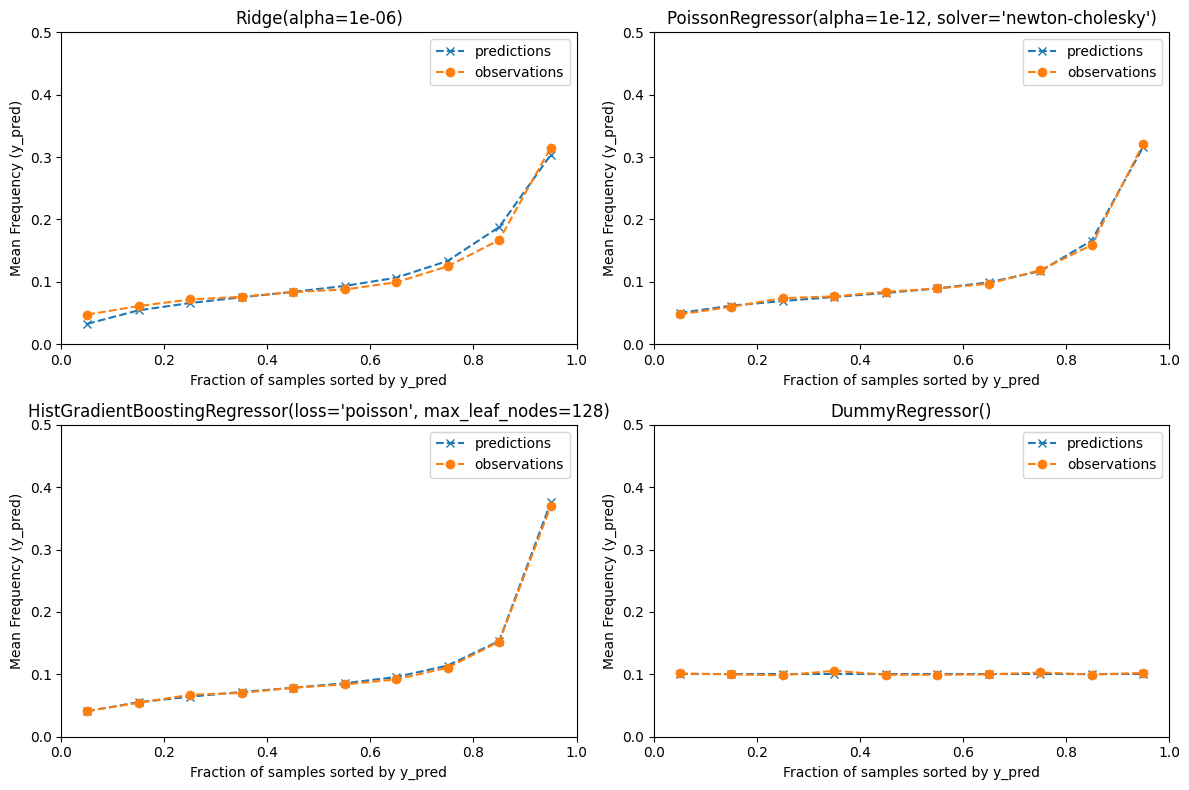

In [12]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

Le modèle de régression "dummy" prédit une fréquence constante. Ce modèle n'attribue pas le même rang lié à tous les échantillons, mais il est néanmoins globalement bien étalonné (pour estimer la fréquence moyenne de l'ensemble de la population).

Le modèle de régression `Ridge` peut prédire des fréquences attendues très faibles qui ne correspondent pas aux données. Il peut donc sous-estimer considérablement le risque pour certains titulaires de police.

`PoissonRegressor` et `HistGradientBoostingRegressor` montrent une meilleure cohérence entre les valeurs prévues et observées, en particulier pour les valeurs cibles prévues faibles.

La somme de toutes les prédictions confirme également le problème d'étalonnage du modèle `Ridge` : il sous-estime de plus de 3 % le nombre total de réclamations dans l'ensemble de test, tandis que les trois autres modèles peuvent approximativement récupérer le nombre total de réclamations du portefeuille de test.

# Évaluation du pouvoir de classement

Pour certaines applications commerciales, nous nous intéressons à la capacité du modèle à classer du plus risqué au plus sûr les titulaires de police, indépendamment de la valeur absolue de la prédiction. Dans ce cas, l'évaluation du modèle traiterait le problème comme un problème de classement plutôt qu'un problème de régression.

Pour comparer les 3 modèles de cette perspective, on peut tracer la proportion cumulative de réclamations par rapport à la proportion cumulative d'exposition pour les échantillons de test classés selon les prédictions du modèle, du plus sûr au plus risqué selon chaque modèle.

Ce graphique est appelé courbe de Lorenz et peut être résumé par l'indice de Gini :

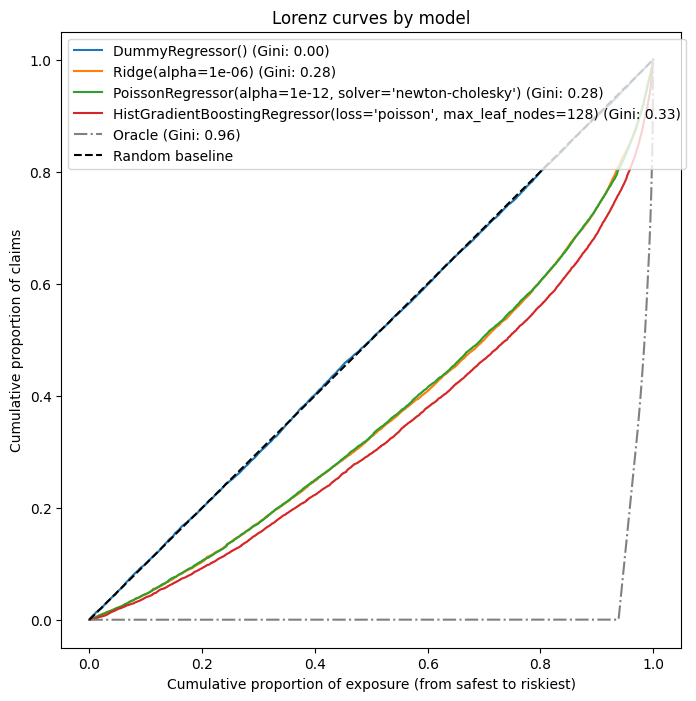

In [13]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(8, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(
        df_test["Frequency"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    df_test["Frequency"], df_test["Frequency"], df_test["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)
ax.legend(loc="upper left")

Comme prévu, le régresseur "dummy" est incapable de classer correctement les échantillons et se comporte donc le moins bien sur ce graphique.

Le modèle basé sur les arbres est nettement meilleur pour classer les titulaires de police par risque, tandis que les deux modèles linéaires se comportent de manière similaire.

Les trois modèles sont nettement meilleurs que le hasard, mais restent également très loin de faire des prédictions parfaites.

Ce dernier point est attendu en raison de la nature du problème : l'occurrence des accidents est principalement dominée par des causes circonstancielles qui ne sont pas capturées dans les colonnes de l'ensemble de données et peuvent en effet être considérées comme purement aléatoires.

Les modèles linéaires supposent l'absence d'interactions entre les variables d'entrée, ce qui provoque probablement une sous-estimation. L'ajout d'un extracteur de caractéristiques polynomiales ([**`PolynomialFeatures`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) augmente en effet leur pouvoir discriminant de 2 points d'indice de Gini. En particulier, il améliore la capacité des modèles à identifier les 5 % des profils les plus risqués.

# Principales conclusions

- La performance des modèles peut être évaluée en fonction de leur capacité à produire des prédictions bien étalonnées et un bon classement.
- L'étalonnage du modèle peut être évalué en traçant la valeur observée moyenne par rapport à la valeur prédite moyenne sur des groupes d'échantillons de test regroupés par risque prédit.
- La perte des moindres carrés (avec l'utilisation implicite de la fonction de liaison identité) du modèle de régression Ridge semble provoquer un mauvais étalonnage de ce modèle. En particulier, il a tendance à sous-estimer le risque et peut même prédire des fréquences négatives invalides.
- L'utilisation de la perte de Poisson avec une liaison logarithmique peut corriger ces problèmes et conduire à un modèle linéaire bien étalonné.
- L'indice de Gini reflète la capacité d'un modèle à classer des prédictions indépendamment de leurs valeurs absolues, et n'évalue donc que leur pouvoir de classement.
- Malgré l'amélioration de l'étalonnage, le pouvoir de classement des deux modèles linéaires est comparable et bien inférieur au pouvoir de classement des arbres de régression à gradient boosting.
- La déviance de Poisson calculée en tant que métrique d'évaluation reflète à la fois l'étalonnage et le pouvoir de classement du modèle. Elle suppose également une hypothèse linéaire sur la relation idéale entre la valeur attendue et la variance de la variable de réponse. Dans un souci de concision, nous n'avons pas vérifié si cette hypothèse était vérifiée.
- Les métriques de régression traditionnelles telles que l'erreur quadratique moyenne et l'erreur absolue moyenne sont difficiles à interpréter de manière significative sur des valeurs de comptage avec de nombreux zéros.